# Python для DataScience
## Курсовая работа

В этой курсовой работе мы будем обучать модель, предсказывающую цены на квартиры

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### Загрузка данных

Скачаем датасеты:

In [2]:
from urllib import request
from os.path import isfile

train_url = 'https://uploads.hb.cldmail.ru/asset/1381522/attachment/302b3d11658ce764f4e8655292566e11.csv'
test_url = 'https://uploads.hb.cldmail.ru/asset/1381521/attachment/f74867a92dc85932950369d8d31db3b0.csv'

train_path = 'train.csv'
test_path = 'test.csv'

if not isfile(train_path):
    request.urlretrieve(train_url, train_path)
if not isfile(test_path):
    request.urlretrieve(test_url, test_path)

In [4]:
data = pd.read_csv(train_path)

### Очистка данных
Давайте проанализируем датасет

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
Id               10000 non-null int64
DistrictId       10000 non-null int64
Rooms            10000 non-null float64
Square           10000 non-null float64
LifeSquare       7887 non-null float64
KitchenSquare    10000 non-null float64
Floor            10000 non-null int64
HouseFloor       10000 non-null float64
HouseYear        10000 non-null int64
Ecology_1        10000 non-null float64
Ecology_2        10000 non-null object
Ecology_3        10000 non-null object
Social_1         10000 non-null int64
Social_2         10000 non-null int64
Social_3         10000 non-null int64
Healthcare_1     5202 non-null float64
Helthcare_2      10000 non-null int64
Shops_1          10000 non-null int64
Shops_2          10000 non-null object
Price            10000 non-null float64
dtypes: float64(8), int64(9), object(3)
memory usage: 1.5+ MB


In [10]:
data.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.00000,10000.000000,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,8383.40770,50.400800,1.890500,56.315775,37.199645,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,214138.857399
std,4859.01902,43.587592,0.839512,21.058732,86.241209,28.560917,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341,92872.293865
min,0.00000,0.000000,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,4169.50000,20.000000,1.000000,41.774881,22.769832,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942
50%,8394.50000,36.000000,2.000000,52.513310,32.781260,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879
75%,12592.50000,75.000000,2.000000,65.900625,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171
max,16798.00000,209.000000,19.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


Мы видим ряд результатов, давайте определим ряд заявлений:

#### 25% данных о размерах кухни составляют 1, что не похоже на правду. 
Если это так, то данным признаком следует пренебречь, так как он крайне неточен

Для начала, построим гистограмму распределения квартир по площадям кухни

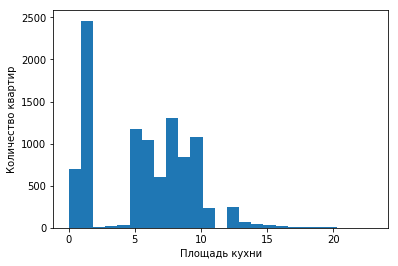

In [42]:
plt.hist(
    data['KitchenSquare'].loc[data.KitchenSquare < 25], 
    bins=25
)

plt.xlabel('Площадь кухни')
plt.ylabel('Количество квартир')
plt.show();

Давайте вычислим среднюю площадь квартиры, имеющую кухню площадью 1, а также общий процент таких квартир среди всей выборки

In [37]:
square_with_tiny_kitchen = data.loc[data.KitchenSquare <= 1]['Square'].loc[data.Square < 100]

In [38]:
square_with_tiny_kitchen.mean(), square_with_tiny_kitchen.count() / data['Square'].count()

(57.808910788199775, 0.3045)

Выходит, что 30% квартир имеют площадь кухни 1 и менее, при том что средняя площать среди них 57. Можно было бы объяснить отсутсвие кухонь в случае если объект является общежитием или апартаментами, но не с такой средней площадью. Из этого можно заключить что признак `KitchenSquare` невалиден и должен быть исключен из выборки.

#### 48% записей не имеют значения  `Healthcare_1`. 
Если этот признак не кореллирует с другими параметрами то его можно исключить из выборки.

Давайте возьмем все непустые значения и оценим

In [64]:
health_param_1 = data[data.Healthcare_1.notnull()]

In [65]:
health_param_1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5202 entries, 1 to 9999
Data columns (total 20 columns):
Id               5202 non-null int64
DistrictId       5202 non-null int64
Rooms            5202 non-null float64
Square           5202 non-null float64
LifeSquare       4457 non-null float64
KitchenSquare    5202 non-null float64
Floor            5202 non-null int64
HouseFloor       5202 non-null float64
HouseYear        5202 non-null int64
Ecology_1        5202 non-null float64
Ecology_2        5202 non-null object
Ecology_3        5202 non-null object
Social_1         5202 non-null int64
Social_2         5202 non-null int64
Social_3         5202 non-null int64
Healthcare_1     5202 non-null float64
Helthcare_2      5202 non-null int64
Shops_1          5202 non-null int64
Shops_2          5202 non-null object
Price            5202 non-null float64
dtypes: float64(8), int64(9), object(3)
memory usage: 853.5+ KB


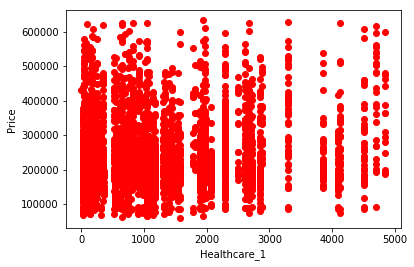

In [66]:
plt.plot(
    health_param_1['Healthcare_1'],
    health_param_1['Price'],
    'ro'
)
plt.xlabel('Healthcare_1')
plt.ylabel('Price')
plt.show();

In [67]:
health_param_1[['Healthcare_1', 'Helthcare_2', 'Price']].corr()

,Healthcare_1,Helthcare_2,Price
Healthcare_1,1.000000,0.203177,0.138755
Helthcare_2,0.203177,1.000000,0.135872
Price,0.138755,0.135872,1.000000


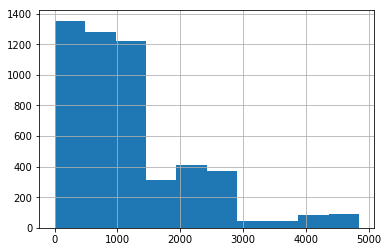

In [68]:
health_param_1['Healthcare_1'].hist()

In [69]:
health_param_1.corr()['Healthcare_1']

Id              -0.003879
DistrictId       0.304335
Rooms            0.042857
Square          -0.039748
LifeSquare      -0.026867
KitchenSquare    0.009472
Floor           -0.138294
HouseFloor      -0.143973
HouseYear       -0.011969
Ecology_1       -0.043547
Social_1         0.077133
Social_2         0.050458
Social_3         0.133877
Healthcare_1     1.000000
Helthcare_2      0.203177
Shops_1          0.057758
Price            0.138755
Name: Healthcare_1, dtype: float64

Выходит, что признак 'Healthcare_1' не кореллирует с остальными, и поскольку заполнен лишь на 50% то он также невалиден и им можно принебречь

#### Оценим признак `Rooms`

In [71]:
data['Rooms'].describe()

count    10000.000000
mean         1.890500
std          0.839512
min          0.000000
25%          1.000000
50%          2.000000
75%          2.000000
max         19.000000
Name: Rooms, dtype: float64

In [76]:
data['Rooms'].value_counts()

2.0     3880
1.0     3705
3.0     2235
4.0      150
5.0       18
0.0        8
10.0       2
19.0       1
6.0        1
Name: Rooms, dtype: int64

Посмотрим на выбросы, когда количество комнат >5:

In [78]:
data[data.Rooms > 5]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
377,5927,57,10.0,59.056975,36.223072,10.0,22,22.0,2002,0.090799,B,B,74,19083,2,NaN,5,15,B,317265.323792
1454,8491,1,19.0,42.006046,21.779288,7.0,17,17.0,2014,0.007122,B,B,1,264,0,NaN,0,1,B,78364.616704
2170,14003,99,6.0,59.414334,38.702244,6.0,7,9.0,1969,0.033494,B,B,66,10573,1,1322.0,3,8,B,229661.964416
8849,14865,9,10.0,60.871266,38.420681,10.0,3,2.0,1994,0.161532,B,B,25,5648,1,30.0,2,4,B,172329.270863
